In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch import Tensor, FloatTensor, ByteTensor
import os
import sys
import random
import warnings
from torch.utils.data import Dataset, DataLoader
from torch.nn import init
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize, rotate
from skimage.morphology import label
import time

from sklearn.model_selection import train_test_split
from model import UNet
from scipy.signal import convolve


In [272]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, masks = sample['image'], sample['mask']
        return {'image': torch.from_numpy(image),
                'mask': torch.from_numpy(masks),
                'size': sample['size'],
                'id' : sample['id']}

RESHAPE_SIZE = 256
class ImageDataSet(Dataset):
    def __init__(self, PATH, mask=False, transform=None, mode='full', specify_index=None):
        
        
        self.PATH = PATH
        self.ids = next(os.walk(self.PATH))[1]
        
        if specify_index == None:
            self.len = len(self.ids)
            self.index = range(self.len)
            
        else:
            self.len = len(specify_index)
            self.index = specify_index
            
        
        self.mask = mask
        self.transform = transform
        self.mode = mode
        self.Image = np.zeros((self.len, RESHAPE_SIZE, RESHAPE_SIZE))
        self.Mask = []
        self.OrigSize = np.zeros((self.len, 2))
        self.ID = np.zeros(self.len, dtype='object')
        
        
        for idx in tqdm(range(self.len)):
            
            id_ = self.ids[idx]
            img = imread(self.PATH + id_ + '/images/' + id_ + '.png')
            self.OrigSize[idx] = img.shape[:2]
            img = resize(img, (RESHAPE_SIZE, RESHAPE_SIZE), mode='constant', preserve_range=True)[:,:,0]
            self.Image[idx]  = img
            self.ID[idx] = id_
            if self.mask:
                masks = []
                self.mask_ids = next(os.walk(self.PATH + '/' + id_ + '/masks/'))[2]

                for m_id in self.mask_ids:

                    img = imread(self.PATH + id_ + '/masks/' + m_id )
                    img = (resize(img, (RESHAPE_SIZE, RESHAPE_SIZE), mode='constant', preserve_range=True)).astype(bool)
                    masks.append(img)

                self.Mask.append(masks)
#                 if self.mode == 'full':
#                     self.Mask[idx] = np.array(masks).sum(0).astype(bool).astype(int)
                    
            else:
                self.Mask.append(np.zeros((RESHAPE_SIZE, RESHAPE_SIZE)))
        
    def __len__(self):
        return self.len
    
    
    def __getitem__(self, idx):
        
        sample = {}
        
        sample['size'] = self.OrigSize[idx]
        sample['id'] = self.ID[idx]
        
        if self.mode == 'full':
            image = self.Image[idx]
            mask = np.array(self.Mask[idx]).sum(0).astype(bool).astype(int)
            

            
        elif self.mode == 'aug':
            img = self.Image[idx]
            #create new mask
            mask = np.array(list(filter(lambda x: np.random.rand(1) > 0.5, self.Mask[idx]))).sum(0).astype(bool).astype(int)
            #smooth outlines to mask image
            ker = np.array([[0.1,0.3,0.1],[0.3,1,0.3],[0.1,0.3,0.1]])[:,:,None]
            mask_outline = convolve(mask[:,:,None].astype(int), ker, mode='same').squeeze()
            mask_outline = (mask_outline > 1) + mask_outline * (mask_outline <1)
            new_image = self.Image[idx] * mask_outline
            #pack it
            sample['mask'] = mask
            sample['image'] = new_image
        
        elif self.mode == 'aug2':
            
            image = self.Image[idx]
            mask = np.array(self.Mask[idx]).sum(0).astype(bool).astype(int)
            
            flip = np.random.rand() > 0.5
            rot = np.random.randint(0,3)  
            
            if flip:
                image = np.flip(image, 1).copy()
                mask = np.flip(mask, 1).copy()
            
            image = np.rot90(image, k=rot).copy()
            mask = np.rot90(mask, k=rot).copy()


        sample['image'] = image          
        sample['mask'] = mask

        if self.transform:
            sample = self.transform(sample)
            
            
        return sample
    
    def foo(self, idx):
        sample = {}
        sample['image'] = self.Image[idx]
        sample['mask'] = np.array(self.Mask[idx]).sum(0).astype(bool).astype(int)
        return sample

In [273]:
def save_checkpoint(model, filename='checkpoint.pth.tar'):
    torch.save(model.state_dict(), filename)

def load_checkpoint(model, filename='checkpoint.pth.tar'):
    model.load_state_dict( torch.load(filename) )


In [342]:
train_idx, control_idx = train_test_split(range(670), test_size=0.1 )

In [344]:

train_dataset = ImageDataSet(PATH='./data/stage1_train/',
                            specify_index=None,
                            mask=True,
                            mode='full',
                            transform = ToTensor() )

# control_dataset = ImageDataSet(PATH='./data/stage1_train/',
#                             specify_index=control_idx,
#                             mode='full',
#                             mask=True,
#                             transform = ToTensor() )


test_dataset = ImageDataSet(PATH='./data/stage1_test/',
                            specify_index=None,
                            mask=False,
                            transform=ToTensor() )


100%|██████████| 65/65 [00:01<00:00, 58.80it/s]


In [345]:
train_dataloader = DataLoader(train_dataset, batch_size=8,
                        shuffle=True, num_workers=4)


# control_dataloader = DataLoader(control_dataset, batch_size=8,
#                         shuffle=True, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=8,
                        shuffle=False, num_workers=4)

In [346]:
dtype=torch.FloatTensor

def train(network, epochs, learning_rate, loss=torch.nn.CrossEntropyLoss(), optim=torch.optim.Adam):
    train_loss_epochs = []
    test_loss_epochs = []
    optimizer = optim(network.parameters(), lr=learning_rate)
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for sample in train_dataloader:
                
                X = sample['image']
                X = Variable(X).type(dtype)[:,None]
                y = sample['mask']
                y = Variable(y).type(torch.LongTensor)
                
                if use_cuda:
                    X, y = X.cuda(), y.cuda()
                
                prediction = network(X)
                #print ('pred:', prediction.shape)
                #print ('y', y.shape)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.data[0])
                optimizer.zero_grad()
                loss_batch.backward()
                optimizer.step()
  
            train_loss_epochs.append(np.mean(losses))
            losses = []    
            for sample in control_dataloader:
                X = sample['image'].cuda()
                X = Variable(X).type(dtype)[:,None]
                y = sample['mask'].cuda()
                y = Variable(y).type(torch.LongTensor)
                
                if use_cuda:
                    X, y = X.cuda(), y.cuda()
                
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.data[0])
                
            test_loss_epochs.append(np.mean(losses))
            sys.stdout.write('\rEpoch {0}... (Train/Control) Loss: {1:.3f}/{2:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1]))
        

    except KeyboardInterrupt:
        pass
    
    best_test = min(test_loss_epochs[1:])
    best_train = min(train_loss_epochs[1:])
    
  
    
    plt.figure(figsize=(12, 5))
    plt.plot(train_loss_epochs[1:], label='Train')
    plt.plot(test_loss_epochs[1:], label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

In [347]:
use_cuda = torch.cuda.is_available() 
if use_cuda:
    torch.cuda.manual_seed(42)
    torch.cuda.set_device(1)

In [348]:
use_cuda

True

In [349]:
#https://github.com/jaxony/unet-pytorch
model = UNet(num_classes=2, in_channels=1, depth=5)
if use_cuda:
    model = model.cuda()

Запускал train много раз

Epoch 9... (Train/Control) Loss: 0.093/0.102

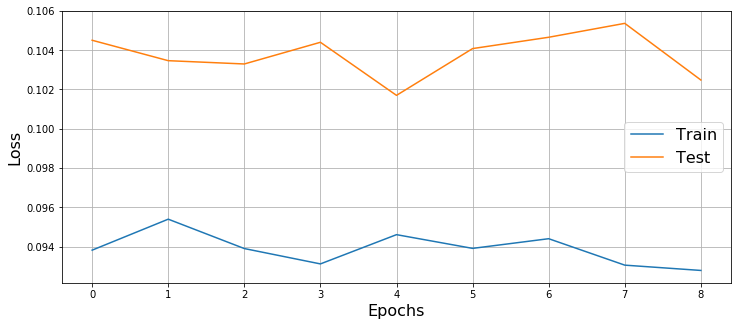

In [366]:
train(model, 10, learning_rate=0.000001)

In [367]:
save_checkpoint(model, 'chp2.pth.tar')

In [293]:
load_checkpoint(model,'chp2.pth.tar')

## Find best cutoff

In [368]:
def iou(pred, y, cutoff=0.5):
    pred = pred.data.cpu().numpy() > cutoff
    y = y.data.cpu().numpy()

    
#     plt.imshow(y)
#     plt.show()
#     plt.imshow(pred)
#     plt.show()

    return (pred * y).sum() / (pred | y).sum()

In [369]:
sm = torch.nn.Softmax(dim=1)
S = np.linspace(0,1,101)
losses_n = []

for sample in train_dataloader:
    X = sample['image'].cuda()
    X = Variable(X).type(dtype)[:,None]
    y = sample['mask'].cuda()
    y = Variable(y).type(torch.LongTensor)

    if use_cuda:
        X, y = X.cuda(), y.cuda()

    prediction = model(X)
    pred = sm(prediction)[:,1]
    
    for n in range(pred.shape[0]):
        j = []
        for s in S:
            j.append(iou(pred[n], y[n], s))
        losses_n.append(j)


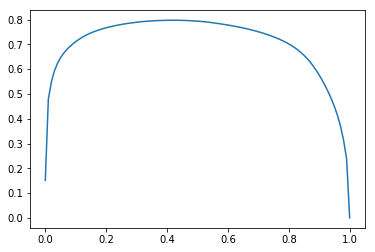

In [370]:
losses = np.array(losses_n).mean(0)
plt.plot(S, losses)
plt.show()

In [371]:
S[losses.argmax()]

0.42

In [375]:
n = 4

sample = next(iter(test_dataloader))
X = Variable((sample['image']).type(torch.FloatTensor))[:,None]
y = sample['mask'].numpy()

if use_cuda:
    X = X.cuda()
    
y_pred = model(X)
sm = nn.Softmax(dim=1)
pred = sm(y_pred).data.cpu().numpy()[:,1]

# plt.imshow(X[n,0].data.cpu().numpy(), cmap='gray')
# plt.show()
# plt.imshow(pred[n]>0.45, cmap='gray')
# plt.show()

## Submision

In [376]:
preds_test_upsampled = []
test_ids = []

sm = torch.nn.Softmax(dim=1)
for sample in test_dataloader:

    ID = sample['id']
    SIZE = sample['size'].numpy()
    X = Variable((sample['image']).type(torch.FloatTensor))[:,None]
    if use_cuda:
        X = X.cuda()
    y_pred = model(X)
    preds_test = sm(y_pred).data.cpu().numpy()[:,1]
    
    #prediction unsample
    for i in range(preds_test.shape[0]):
        preds_test_upsampled.append(   resize(preds_test[i], 
                                           (SIZE[i][0], SIZE[i][1]),
                                           mode='constant', preserve_range=True))
    test_ids.extend(ID)

In [377]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)


new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n], 0.5))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [378]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018.csv', index=False)


In [379]:
input_path = './data/stage1_test/'
masks = [f for f in os.listdir(input_path) if f.endswith('_mask.tif')]


In [380]:
sub.head()

,ImageId,EncodedPixels
0,1cdbfee1951356e7b0a215073828695fe1ead5f8b1add1...,74755 3 75267 5 75779 7 76290 9 76802 9 77314 ...
1,1cdbfee1951356e7b0a215073828695fe1ead5f8b1add1...,168454 2 168965 4 169476 5 169987 7 170499 7 1...
2,1cdbfee1951356e7b0a215073828695fe1ead5f8b1add1...,162308 2 162819 4 163331 4 163844 2
3,1cdbfee1951356e7b0a215073828695fe1ead5f8b1add1...,126995 2
4,1cdbfee1951356e7b0a215073828695fe1ead5f8b1add1...,41 5 550 56 1062 58 1573 60 2085 60 2596 63 31...
